In [1]:
import torch
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
%matplotlib inline

pyro.set_rng_seed(101)

In [2]:
A_alias = ['young','adult','old']
S_alias = ['M','F']
E_alias = ['high','uni']
O_alias = ['emp','self']
R_alias = ['small','big']
T_alias = ['car','train','other']

A_prob = torch.tensor([0.48,0.36,0.16])
S_prob = torch.tensor([0.45,0.55])
E_prob = torch.tensor([[[0.81,0.19], [0.72,0.28], [0.89,0.11]],
                     [[0.16,0.84], [0.64, 0.36], [0.84,0.16]]])
O_prob = torch.tensor([[0.98,0.02], [0.97,0.03]])
R_prob = torch.tensor([[0.28,0.72], [0.06,0.94]])
T_prob = torch.tensor([[[0.55,0.37,0.08], [0.73,0.02,0.25]],
                     [[0.71,0.15,0.14], [0.68,0.16,0.16]]])

def model():
    A = pyro.sample("A", dist.Categorical(probs=A_prob))
    S = pyro.sample("S", dist.Categorical(probs=S_prob))
    E = pyro.sample("E", dist.Categorical(probs=E_prob[S][A]))
    O = pyro.sample("O", dist.Categorical(probs=O_prob[E]))
    R = pyro.sample("R", dist.Categorical(probs=R_prob[E]))
    T = pyro.sample("T", dist.Categorical(probs=T_prob[R][O]))
    return{'A': A,'S': S,'E': E,'O': O,'R': R,'T': T}

print(model())

{'A': tensor(1), 'S': tensor(1), 'E': tensor(0), 'O': tensor(0), 'R': tensor(1), 'T': tensor(1)}


In [3]:
conditioned_model = pyro.condition(model, data={'E':torch.tensor(1)})

Text(0.5, 1.0, 'P(T | E = uni) - Importance Sampling')

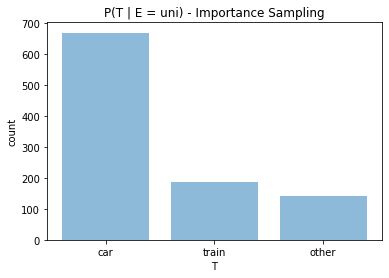

In [4]:
T_posterior = pyro.infer.Importance(conditioned_model, num_samples=1000).run()
T_marginal = EmpiricalMarginal(T_posterior,"T")
T_samples = [T_marginal().item() for _ in range(1000)]
T_unique, T_counts = np.unique(T_samples, return_counts=True)

plt.bar(T_unique, T_counts, align='center', alpha=0.5)
plt.xticks(T_unique, T_alias)
plt.ylabel('count')
plt.xlabel('T')
plt.title('P(T | E = uni) - Importance Sampling')

In [5]:
conditioned_model2 = pyro.condition(model, data={'O':torch.tensor(1), 'R':torch.tensor(1) })

Text(0.5, 1.0, 'P(A | O = self, R = big) - Importance Sampling')

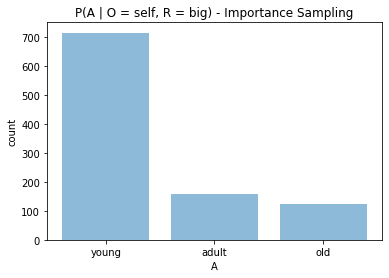

In [6]:
A_posterior = pyro.infer.Importance(conditioned_model2, num_samples=1000).run()
A_marginal = EmpiricalMarginal(A_posterior,"T")
A_samples = [A_marginal().item() for _ in range(1000)]
A_unique, A_counts = np.unique(A_samples, return_counts=True)

plt.bar(A_unique, A_counts, align='center', alpha=0.5)
plt.xticks(A_unique, A_alias)
plt.ylabel('count')
plt.xlabel('A')
plt.title('P(A | O = self, R = big) - Importance Sampling')